In [39]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from pyPhaseLabel import PhaseModel, CrystalPhase, EQ, BackgroundModel, FixedPseudoVoigt
from pyPhaseLabel import create_phases, evaluate_obj, optimize_phase, Lorentz, PseudoVoigt
from julia.Main import Wildcard, Lazytree, search, get_probabilities, get_fraction

## Create phase objects

In [40]:
with open(Path(__file__) / 'data' / 'sticks.csv', 'r') as f:
    t = f.read()

phases = create_phases(t, 0.1, PseudoVoigt(0.5)) # PseudoVoigt has a degree of freedom in peak shape
for idx, phase in enumerate(phases):
    print(idx, phase.name)

0 TaO2_P42/mnm
1 PbTa4O11_R3H
2 TaO_Fm-3m
3 Pb1.49Ta2O6.28_Fd-3mZ
4 Ta2O5_P2mm
5 TaO2_I41/aZ
6 Pb2(Ta1.404Pb0.598)O6.21_Fd-3mZ
7 Ta2O5_Cmmm
8 Ta2O5_C121


## Evaluating objects

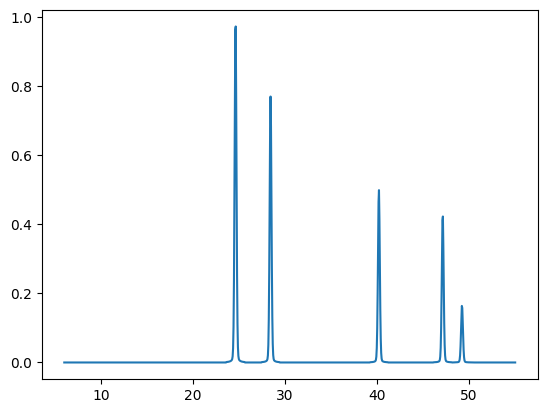

In [41]:
x = np.linspace(6, 55, 1024)
y = np.zeros(1024)
new_phase = CrystalPhase(phases[2], [4.5, 1.0, 0.15, 0.4]) # This modifies the lattice parameters of this cubic phase
t = evaluate_obj(phases[2], x)
plt.plot(x, t)

In [43]:
test_data = (evaluate_obj(new_phase, x)
             + 0.2*np.sin(x/10)
             + 0.1*np.random.randn(1024)+0.2)
bg = BackgroundModel(x, EQ(), 20, 100) # q vector, kernel function, 
p = PhaseModel(phases[2], bg)

std_noise = 0.05
mean = [1., .5, .2] # lattice, activation, width
std = [0.05, 0.05, 0.05] # 

pm, uncer = optimize_phase(p, x, test_data, std_noise, mean, std, maxiter=512, optimize_mode="WithUncer", verbose=False)
print(f"uncer: {uncer}")

uncer: [1.39147030e-08 1.39147030e-08 1.39147030e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.42196168e-04 3.89608938e-04]


In [44]:
print(f"uncer: {np.sqrt(uncer)}")

uncer: [0.00011796 0.00011796 0.00011796 0.         0.         0.
 0.01849855 0.01973851]


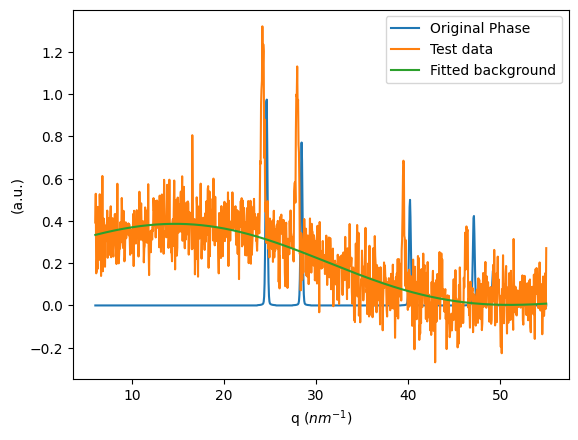

In [50]:
plt.plot(x, t, label="Original Phase")
plt.plot(x, test_data, label="Test data")
# plt.plot(x, evaluate_obj(pm, x), label="Optimized result", linewidth=3)
plt.plot(x, evaluate_obj(pm.background, x), label="Fitted background")
plt.legend()
plt.xlabel("q ($nm^{-1}$)")
plt.ylabel("(a.u.)")
plt.show()

In [51]:
with open(Path(__file__) / 'data' / 'sticks.csv', 'r') as f:
    t = f.read()
tt = t.split("#\n")
tt.remove("")

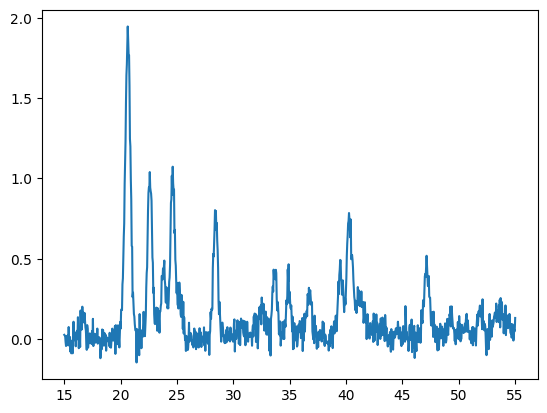

In [52]:
phases = create_phases(t, .2, FixedPseudoVoigt(0.1))
x = np.linspace(15, 55, 1024)

tree = Lazytree(phases[:4], x)

y = evaluate_obj(phases[1:4], x)+ 0.05*np.random.randn(1024)
plt.plot(x, y)
plt.show()

In [53]:
result = search(tree, x, y, 3, 3, .1, False, False, 0.5,
                std_noise, mean, std, optimize_mode="EM",
                maxiter=128, regularization=True)

In [54]:
results = [r for subresults in result[1:] for r in subresults]
probs = get_probabilities(results, x, y, std_noise, mean, std)
ind = np.argmax(probs)
print(get_fraction(results[ind].phase_model.CPs))

[0.57455181 0.1624468  0.26300139]


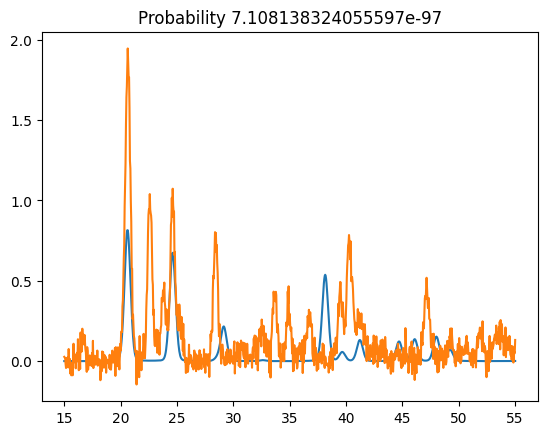

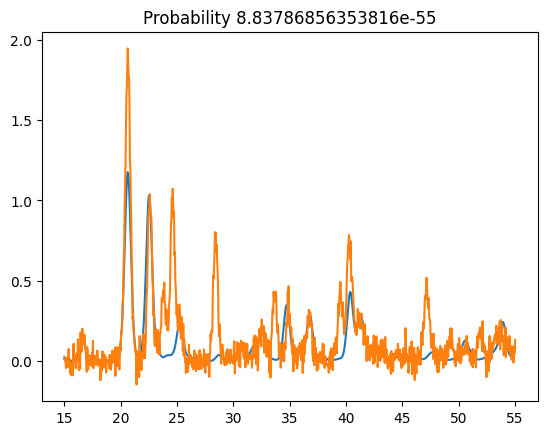

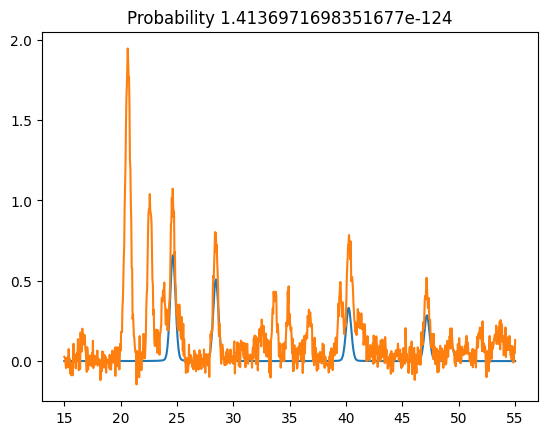

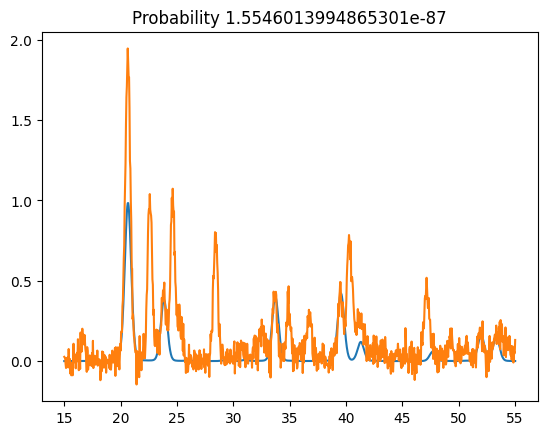

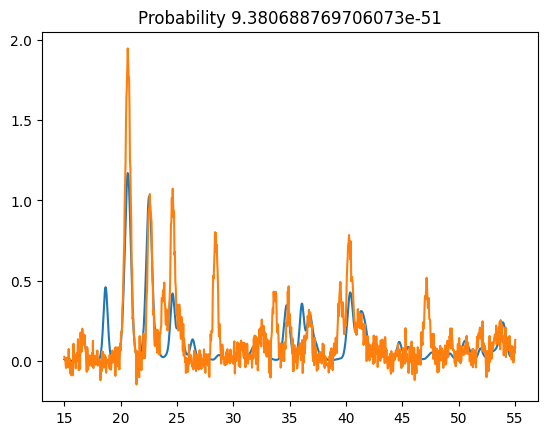

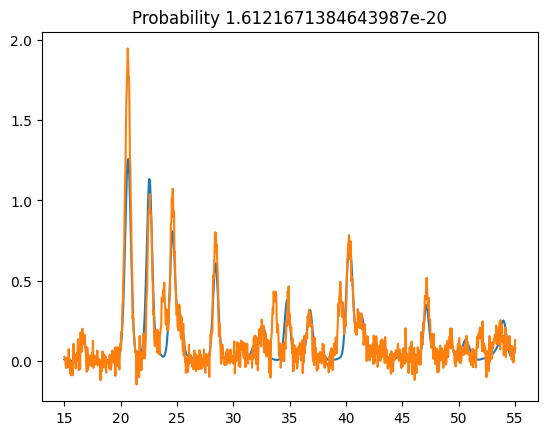

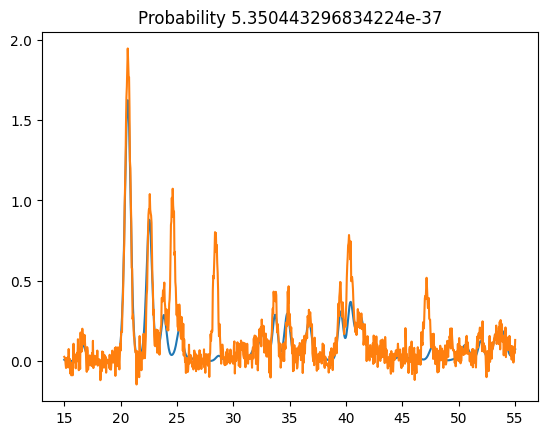

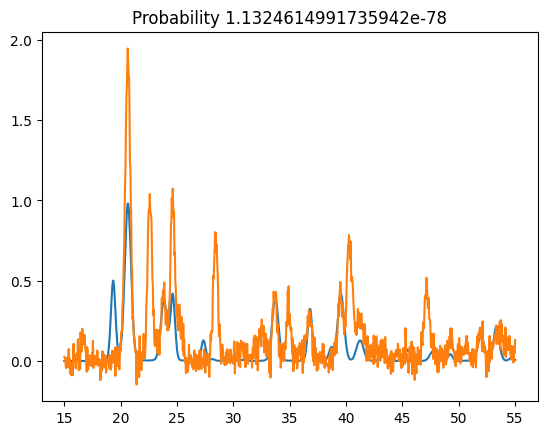

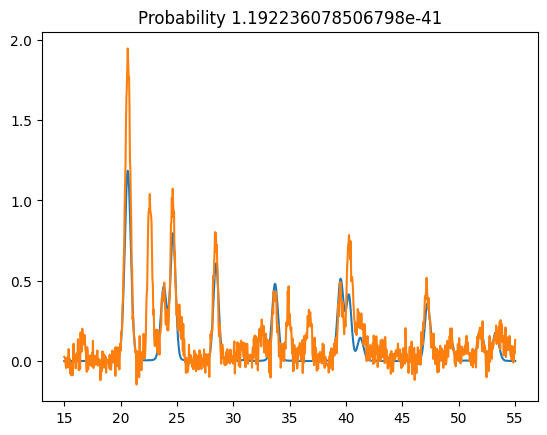

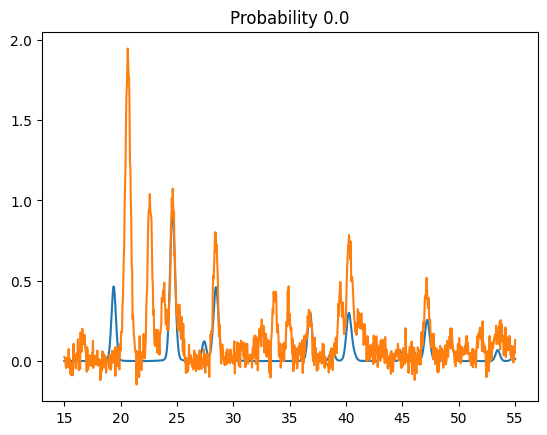

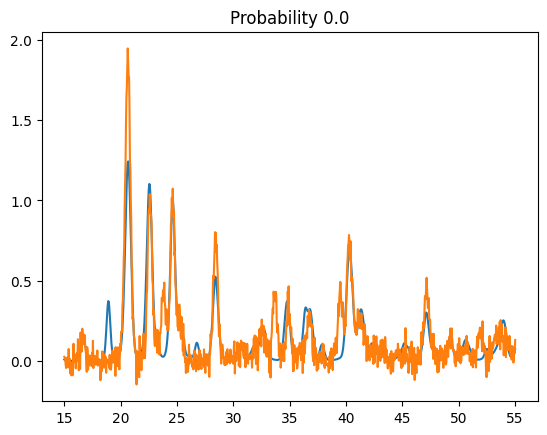

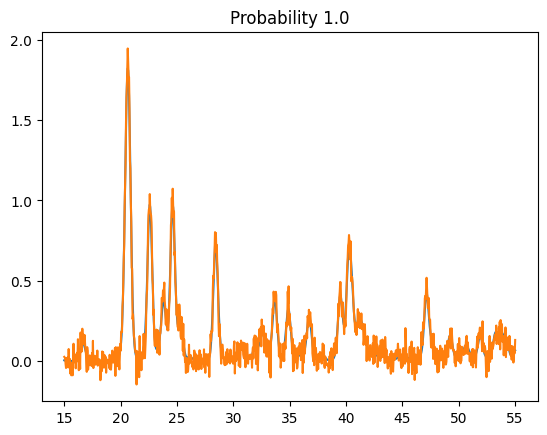

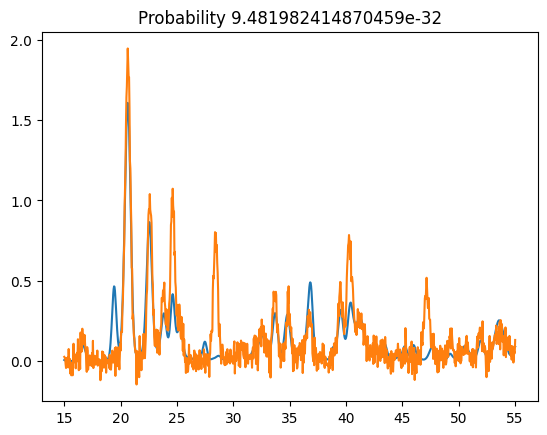

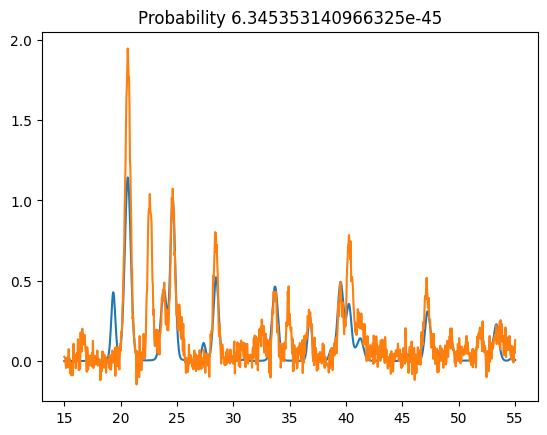

In [55]:
for idx, node in enumerate(results):
   # a = [np.linalg.norm(evaluate_obj(n.phase_model, x)-y) for n in node]
   # ind = np.argmin(a)
   plt.plot(x, evaluate_obj(node.phase_model, x))
   plt.plot(x, y)
   plt.title(f"Probability {probs[idx]}")
   plt.show()